# 02. PyTorch Neural Network Classification

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples, 
                noise=0.03,
                random_state=42) 

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2" : X[:, 1],
                        "label" : y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

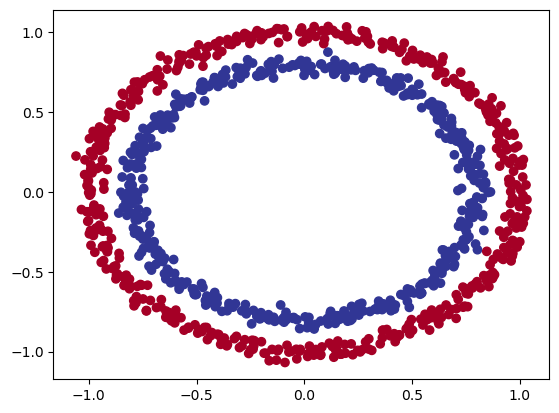

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu);

### 1.1 Input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

In [10]:
# standard pytorch imports
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1814],
        [-0.2274],
        [-0.0543],
        [-0.2175],
        [-0.0439],
        [-0.0720],
        [-0.2097],
        [-0.1734],
        [-0.0551],
        [-0.2305]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer


In [14]:
# Create a loss function
# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()

# create optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [15]:
# calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## 3. Train model

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [16]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1814],
        [-0.2274],
        [-0.0543],
        [-0.2175],
        [-0.0439]], device='cuda:0', grad_fn=<SliceBackward0>)

In [17]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4548],
        [0.4434],
        [0.4864],
        [0.4458],
        [0.4890]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [18]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds, y_pred_labels))

# Get rid of extra dimension
y_preds.squeeze()

tensor([[True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [19]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [20]:
torch.manual_seed(42)

# set the number of epochs
epochs = 100

# put data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                  y_train)

    acc = accuracy_fn(y_true=y_train,
                     y_pred = y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,
                           y_test)
        test_acc = accuracy_fn(y_true = y_test,
                              y_pred = test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69620, Accuracy: 45.12% | Test loss: 0.69281, Test acc: 45.50%
Epoch: 10 | Loss: 0.69501, Accuracy: 46.12% | Test loss: 0.69176, Test acc: 50.00%
Epoch: 20 | Loss: 0.69458, Accuracy: 47.50% | Test loss: 0.69146, Test acc: 53.00%
Epoch: 30 | Loss: 0.69437, Accuracy: 48.38% | Test loss: 0.69140, Test acc: 53.00%
Epoch: 40 | Loss: 0.69423, Accuracy: 48.25% | Test loss: 0.69143, Test acc: 52.50%
Epoch: 50 | Loss: 0.69412, Accuracy: 48.75% | Test loss: 0.69148, Test acc: 53.00%
Epoch: 60 | Loss: 0.69404, Accuracy: 48.75% | Test loss: 0.69155, Test acc: 54.00%
Epoch: 70 | Loss: 0.69395, Accuracy: 48.12% | Test loss: 0.69163, Test acc: 54.00%
Epoch: 80 | Loss: 0.69388, Accuracy: 47.88% | Test loss: 0.69170, Test acc: 54.00%
Epoch: 90 | Loss: 0.69381, Accuracy: 48.50% | Test loss: 0.69178, Test acc: 54.50%


## 4. Make predictions and evaluate the model

In [21]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading the helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", 'wb') as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


In [22]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

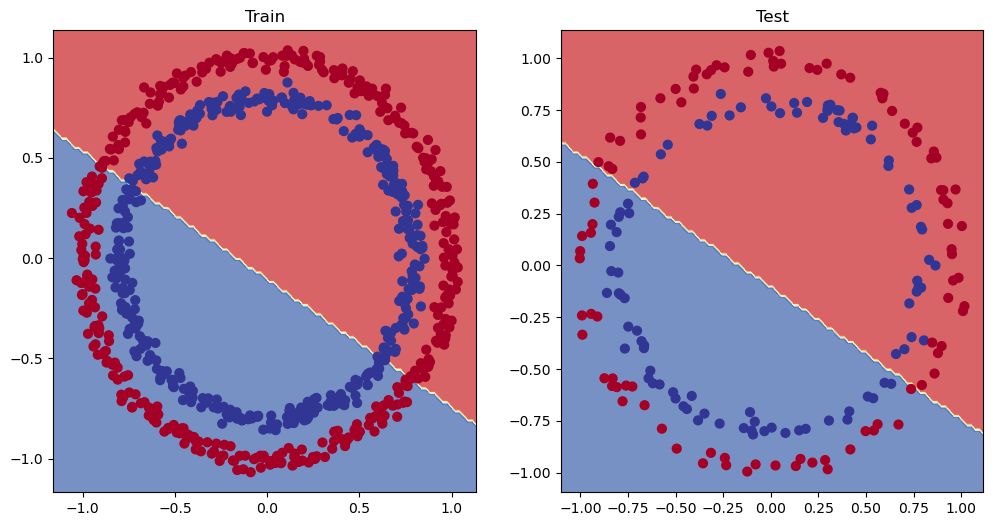

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective) 

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr = 0.1)

In [26]:
torch.manual_seed(42)

epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        
        test_acc = accuracy_fn(y_test,
                               test_pred)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 48.50% | Test Loss: 0.69261, Test acc: 54.50000000000001%
Epoch: 100 | Loss: 0.69305, Accuracy: 48.50% | Test Loss: 0.69379, Test acc: 54.50000000000001%
Epoch: 200 | Loss: 0.69298, Accuracy: 48.50% | Test Loss: 0.69437, Test acc: 54.50000000000001%
Epoch: 300 | Loss: 0.69298, Accuracy: 48.50% | Test Loss: 0.69458, Test acc: 54.50000000000001%
Epoch: 400 | Loss: 0.69298, Accuracy: 48.50% | Test Loss: 0.69465, Test acc: 54.50000000000001%
Epoch: 500 | Loss: 0.69298, Accuracy: 48.50% | Test Loss: 0.69467, Test acc: 54.50000000000001%
Epoch: 600 | Loss: 0.69298, Accuracy: 48.50% | Test Loss: 0.69468, Test acc: 54.50000000000001%
Epoch: 700 | Loss: 0.69298, Accuracy: 48.50% | Test Loss: 0.69468, Test acc: 54.50000000000001%
Epoch: 800 | Loss: 0.69298, Accuracy: 48.50% | Test Loss: 0.69468, Test acc: 54.50000000000001%
Epoch: 900 | Loss: 0.69298, Accuracy: 48.50% | Test Loss: 0.69468, Test acc: 54.50000000000001%


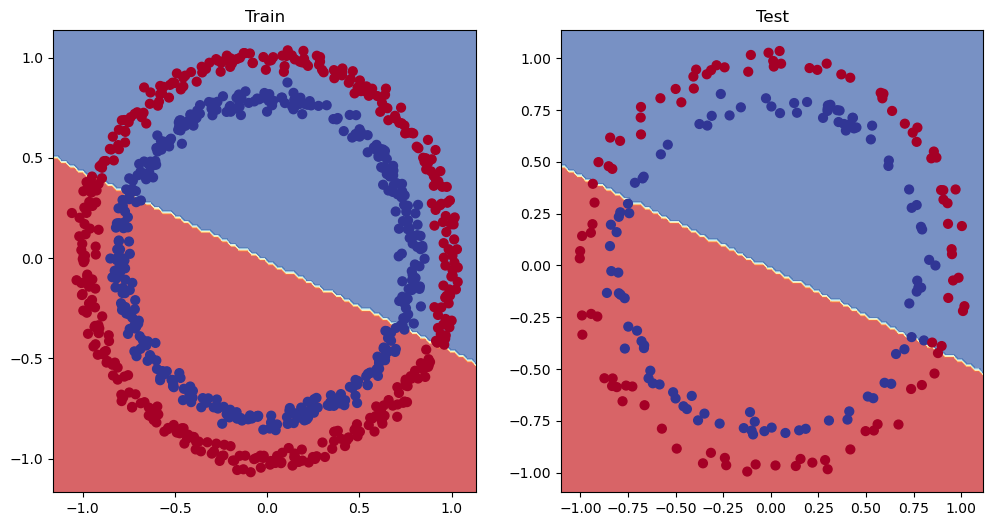

In [27]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)